In [126]:
import importlib
import subprocess

def install_package(package_name, pip_name=None):
    if pip_name is None:
        pip_name = package_name
    if importlib.util.find_spec(package_name) is None:
        print(f'{package_name} not found. Installing...')
        subprocess.run(['pip', 'install', pip_name, '--quiet'])

# Usage
install_package('matplotlib')
install_package('alpha_vantage', 'alpha-vantage')


In [127]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

from alpha_vantage.timeseries import TimeSeries

print("All libraries loaded")

All libraries loaded


In [128]:
config = {
    "alpha_vantage": {
        "key": '29KXSVMSR5B5IYGT',
        "symbol": "SPY",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",

    },
    "data": {
        "window_size": 30,
        "train_split_size": 0.80,
    },
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 16, # since we are using 16 features -- Must align with LSTM Model
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
        "early_stopping_patience": 10,
    }
}

In [129]:
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

start_date = date.today()
print(f"start_date2 is: {start_date}")
end_date = (datetime.today() - timedelta(days=3*365)).date()
print(f"end_date is: {end_date}")


start_date2 is: 2024-08-03
end_date is: 2021-08-04


Number data points 754 from 2021-08-04 to 2024-08-02


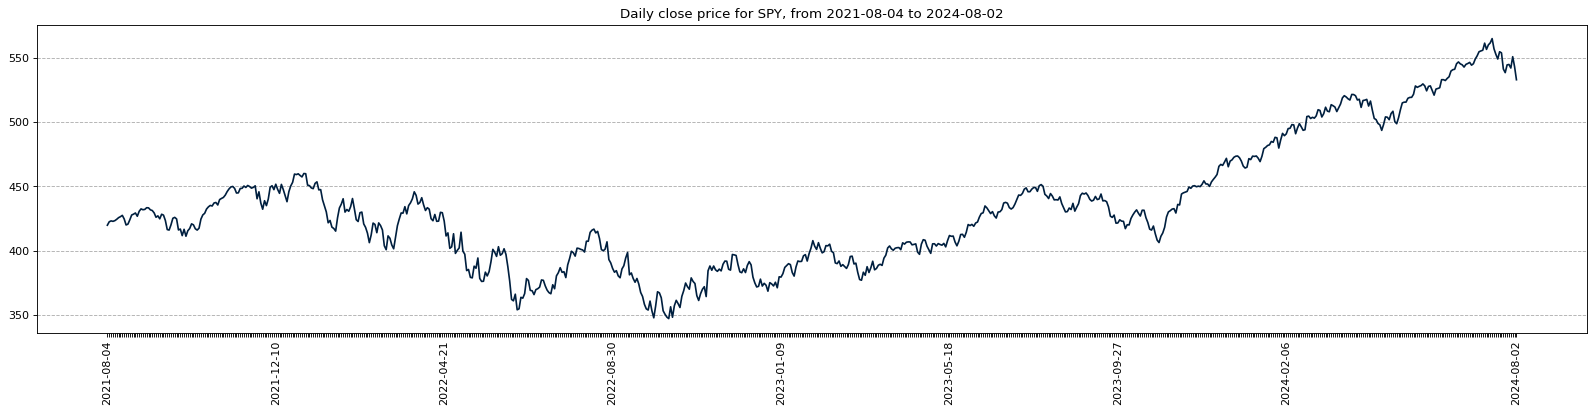

In [130]:
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])


    data_date = [date for date in data.keys()]
    data_date = [date for date in data.keys() if end_date <= datetime.strptime(date, '%Y-%m-%d').date() <= start_date]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data_date]


    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


In [131]:
print(num_data_points)
data_close_price[-1]

754


532.9

<ipython-input-132-102264b42355>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = pd.concat(dfs, axis=1).fillna(method='ffill').dropna()


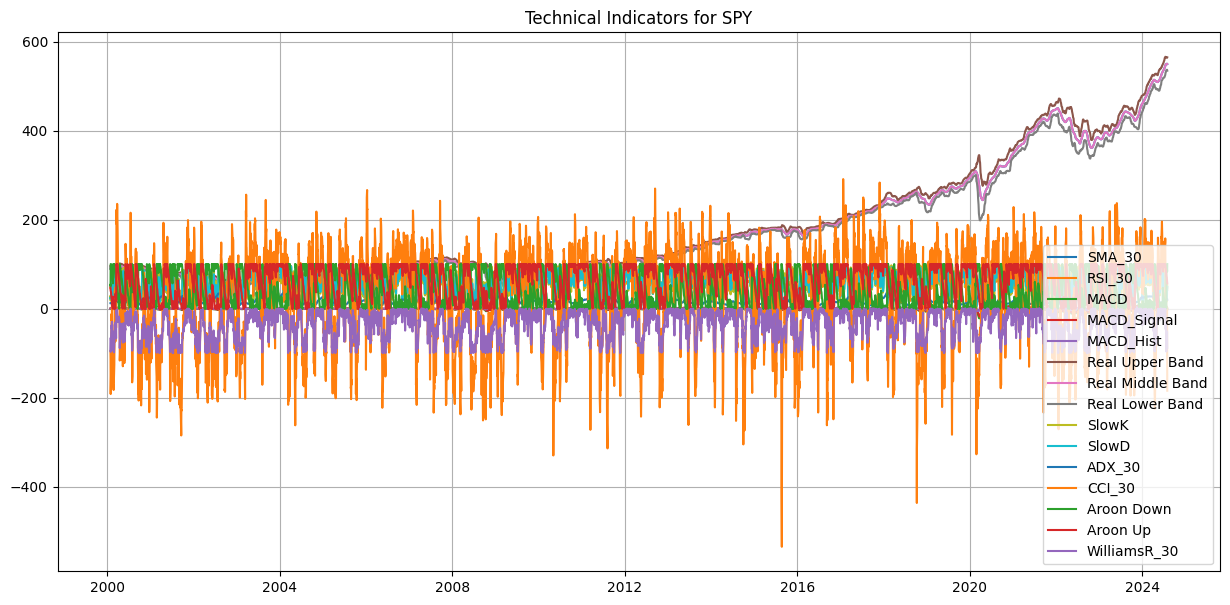

In [132]:
from alpha_vantage.techindicators import TechIndicators
import pandas as pd
import matplotlib.pyplot as plt

def retrieve_technical_indicators(symbol, api_key):
    """
    Retrieve multiple technical indicators for a given stock symbol using Alpha Vantage API.
    """
    ti = TechIndicators(key=api_key, output_format='pandas')

    # Retrieve SMA (Simple Moving Average) data
    sma_data, _ = ti.get_sma(symbol=symbol, interval='daily', time_period=30, series_type='close')
    sma_data = sma_data.rename(columns={'SMA': 'SMA_30'})

    # Retrieve RSI (Relative Strength Index) data
    rsi_data, _ = ti.get_rsi(symbol=symbol, interval='daily', time_period=30, series_type='close')
    rsi_data = rsi_data.rename(columns={'RSI': 'RSI_30'})

    # Retrieve MACD data
    macd_data, _ = ti.get_macd(symbol=symbol, interval='daily', series_type='close')

    # Retrieve Bollinger Bands data
    bbands_data, _ = ti.get_bbands(symbol=symbol, interval='daily', time_period=30, series_type='close')

    # Retrieve Stochastic Oscillator data
    stoch_data, _ = ti.get_stoch(symbol=symbol, interval='daily')

    # Retrieve ADX data
    adx_data, _ = ti.get_adx(symbol=symbol, interval='daily', time_period=30)
    adx_data = adx_data.rename(columns={'ADX': 'ADX_30'})

    # Retrieve CCI data
    cci_data, _ = ti.get_cci(symbol=symbol, interval='daily', time_period=30)
    cci_data = cci_data.rename(columns={'CCI': 'CCI_30'})

    # Retrieve Aroon data
    aroon_data, _ = ti.get_aroon(symbol=symbol, interval='daily', time_period=30)

    # Retrieve Williams %R data
    williamsr_data, _ = ti.get_willr(symbol=symbol, interval='daily', time_period=30)
    williamsr_data = williamsr_data.rename(columns={'WILLR': 'WilliamsR_30'})

    # Merge all the dataframes on date
    dfs = [sma_data, rsi_data, macd_data, bbands_data, stoch_data, adx_data, cci_data, aroon_data, williamsr_data]
    merged_data = pd.concat(dfs, axis=1).fillna(method='ffill').dropna()

    return merged_data


def visualize_data(data, title):
    """
    Visualize the data with multiple features.
    """
    plt.figure(figsize=(15, 7))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

api_key = config["alpha_vantage"]["key"]
symbol = config["alpha_vantage"]["symbol"]

# Retrieve technical indicators
technical_data = retrieve_technical_indicators(symbol, api_key)

# Visualize the retrieved data
visualize_data(technical_data, f"Technical Indicators for {symbol}")


In [133]:
technical_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6169 entries, 2000-01-26 to 2024-08-02
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMA_30            6169 non-null   float64
 1   RSI_30            6169 non-null   float64
 2   MACD              6169 non-null   float64
 3   MACD_Signal       6169 non-null   float64
 4   MACD_Hist         6169 non-null   float64
 5   Real Upper Band   6169 non-null   float64
 6   Real Middle Band  6169 non-null   float64
 7   Real Lower Band   6169 non-null   float64
 8   SlowK             6169 non-null   float64
 9   SlowD             6169 non-null   float64
 10  ADX_30            6169 non-null   float64
 11  CCI_30            6169 non-null   float64
 12  Aroon Down        6169 non-null   float64
 13  Aroon Up          6169 non-null   float64
 14  WilliamsR_30      6169 non-null   float64
dtypes: float64(15)
memory usage: 771.1 KB


In [134]:
class Normalizer():
    def __init__(self):
        self._mu = None
        self._sd = None

    def fit_transform(self, x):
      x_np = np.array(x)
      self._mu = np.mean(x_np, axis=(0), keepdims=True)
      self._sd = np.std(x_np, axis=(0), keepdims=True)
      normalized_x = (x_np - self._mu)/self._sd
      return normalized_x

    def inverse_transform(self, x, feature_idx=0):
      """
    Revert the normalized data back to its original scale.
    :param x: Numpy array of normalized data.
    :param feature_idx: Index of the feature for which the inverse transformation should be applied. Default is 0.
    :return: De-normalized data.
    """
      if self._mu is None or self._sd is None:
        raise ValueError("fit_transform method should be called before inverse_transform.")

    # Adjust for single feature inverse transform
      mu = self._mu[0][feature_idx]
      sd = self._sd[0][feature_idx]

      return (x * sd) + mu

In [135]:
import pandas as pd

# Convert to DataFrame using the 'data_close_price' and 'dates' variables
df_close_price = pd.DataFrame({
    'date': data_date,
    '4. close': data_close_price
})
df_close_price.set_index('date', inplace=True)

# Convert the index of df_close_price to datetime from object
df_close_price.index = pd.to_datetime(df_close_price.index)

# Merge the datasets using an inner join to keep only the common dates
full_data = pd.merge(df_close_price, technical_data, how='inner', left_index=True, right_index=True)

full_data.sort_index(inplace=True)

In [136]:
print(full_data.head())
print(full_data.shape)

num_data_points = len(full_data)
data_date = full_data.index
data_date = pd.to_datetime(full_data.index)

first_date = data_date[0].strftime('%Y-%m-%d')
last_date = data_date[-1].strftime('%Y-%m-%d')
display_date_range = f"from {first_date} to {last_date}"
data_close_price = full_data['4. close']

#display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
print("Number data points", num_data_points, display_date_range)

              4. close    SMA_30   RSI_30    MACD  MACD_Signal  MACD_Hist  \
date                                                                        
2021-08-04  419.892050  414.8812  59.2971  3.2192       3.3553    -0.1360   
2021-08-05  422.551169  415.4921  60.9428  3.2780       3.3398    -0.0618   
2021-08-06  423.249427  416.0465  61.3671  3.3424       3.3403     0.0021   
2021-08-09  422.905080  416.5414  61.0289  3.3272       3.3377    -0.0105   
2021-08-10  423.431165  417.0263  61.3654  3.3195       3.3340    -0.0146   

            Real Upper Band  Real Middle Band  Real Lower Band    SlowK  \
date                                                                      
2021-08-04         424.8156          414.8812         404.9468  55.5538   
2021-08-05         424.9737          415.4921         406.0105  79.1859   
2021-08-06         425.3304          416.0465         406.7627  80.7941   
2021-08-09         425.6505          416.5414         407.4322  93.3379   
2021-08-10

In [137]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(full_data)

single_feature_scaler = MinMaxScaler()
single_feature = full_data[['4. close']]
#single_feature_scaler.fit(single_feature)
normalized_data_close_price = single_feature_scaler.fit_transform(single_feature)

# close_price_scaler = MinMaxScaler()
# normalized_data_close_price = close_price_scaler.fit_transform(full_data['4. close'])

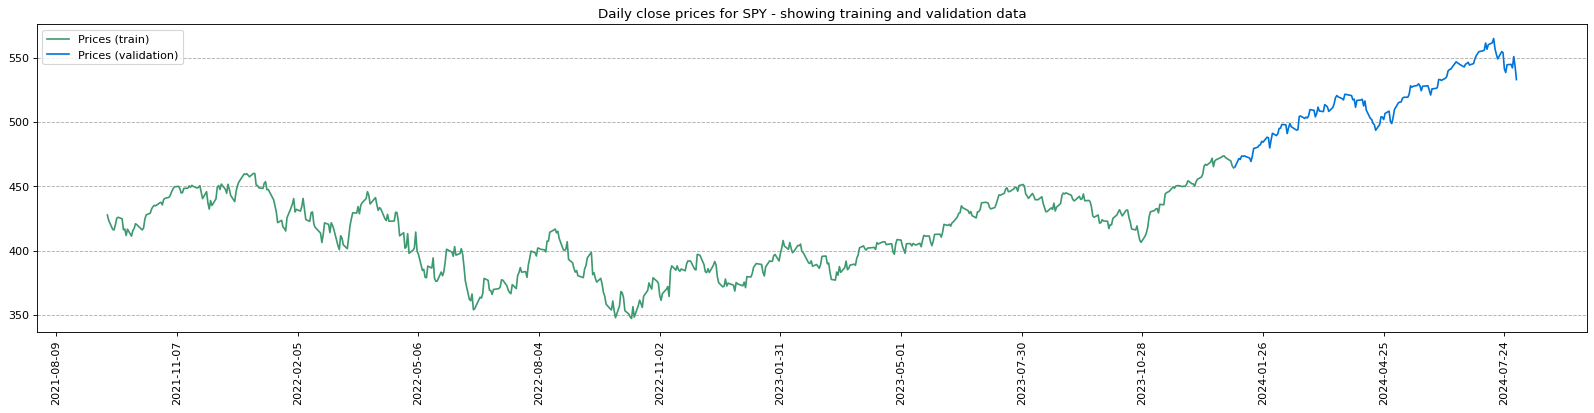

In [138]:
from pandas._config import dates
def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = [x[i:i + window_size] for i in range(n_row - 1)]
    return np.array(output), x[-window_size:]

def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:, 0]  # assuming closing price is the first column
    return output


# Preparing the data
data_x, data_x_unseen = prepare_data_x(normalized_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data, window_size=config["data"]["window_size"])

# Split dataset
split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

# Prepare data for plotting
to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

# Ensure you are inversely transforming the correct dimension
window_size_offset = config["data"]["window_size"]
to_plot_data_y_train[window_size_offset:split_index + window_size_offset] = single_feature_scaler.inverse_transform(data_y_train.reshape(-1, 1)).flatten()
to_plot_data_y_val[split_index + window_size_offset:] = single_feature_scaler.inverse_transform(data_y_val.reshape(-1, 1)).flatten()

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_data(full_data, to_plot_data_y_train, to_plot_data_y_val, config):
    # Extract configuration parameters
    plot_config = config.get("plots", {})
    color_train = plot_config.get("color_train", "blue")
    color_val = plot_config.get("color_val", "red")
    xticks_interval = plot_config.get("xticks_interval", 90)  # Assuming xticks_interval is in days
    symbol = config.get("alpha_vantage", {}).get("symbol", "Unknown Symbol")

    # Prepare data
    data_date = full_data.index
    num_data_points = len(data_date)

    # Create figure
    fig, ax = plt.subplots(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    # Plot data
    ax.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=color_train)
    ax.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=color_val)

    # Set x-ticks
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=xticks_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation='vertical')

    # Set title, grid, legend, and show plot
    ax.set_title(f"Daily close prices for {symbol} - showing training and validation data")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.legend()
    plt.show()

# Usage
plot_data(full_data, to_plot_data_y_train, to_plot_data_y_val, config)



In [139]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        #x = np.expand_dims(x, 2) # in our case.... we have 16 feature
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (579, 30, 16) (579,)
Validation data shape (145, 30, 16) (145,)


In [140]:
#input_size must be set to the above training/validation data shape size's 3rd parameter: 16
class LSTMModel(nn.Module):
    def __init__(self, input_size=16, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [141]:
# Add Artificial Neural Network
class ANNModel(nn.Module):
    def __init__(self, input_size=16, hidden_layer_size=32, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [142]:
# Gated Recurrent Neural Network
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# model = GRUModel(input_size=16, hidden_size=32, num_layers=2, output_size=1, dropout=0.2)
# output = model(torch.randn(64, 30, 16))  # (batch_size, sequence_length, input_size)


In [143]:
def run_epoch(dataloader, model_type, is_training=False):
    epoch_loss = 0

    if is_training:
        model_type.train()
    else:
        model_type.eval()

    #for idx, (x, y) in enumerate(dataloader):
    for x, y in dataloader:
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model_type(x)

        # Check shapes and print them for debugging
        #print("Shape of out:", out.shape)
        #print("Shape of y:", y.shape)

        # Reshape out to match y
        out = out.view(out.size(0), -1).mean(dim=1)

        #loss = criterion(out.contiguous(), y.contiguous())
        loss = criterion(out,y)


        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [144]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

In [145]:
# Initialize the LSTM model
lstmmodel = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
lstmmodel = lstmmodel.to(config["training"]["device"])

In [146]:
# Initialize the ANN model
annmodel = ANNModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], output_size=1, dropout=config["model"]["dropout"])
annmodel = annmodel.to(config["training"]["device"])

In [147]:
# Initialize the GRU model
grumodel = GRUModel(input_size=16, hidden_size=32, num_layers=2, output_size=1, dropout=0.2)
grumodel = grumodel.to(config["training"]["device"])

In [148]:
# List of initialized models
model_types = []

In [149]:
# Add initialized models to the list
model_types.append(lstmmodel)
model_types.append(annmodel)
model_types.append(grumodel)

In [150]:
# iterate through each initialized model type to get model and iterate through list for number of epochs
for model_type in model_types:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_type.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)
    # print the start time of the model training
    print(f"Start time for {model_type} is: {datetime.now()}")
    for epoch in range(config["training"]["num_epoch"]):
        # Run the training and validation epoch
        loss_train, lr_train = run_epoch(train_dataloader, model_type, is_training=True)
        loss_val, lr_val = run_epoch(val_dataloader, model_type)
        scheduler.step()

        #print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
        #      .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
    # print the end time of the model training
    print(f"End time for {model_type} is: {datetime.now()}")

Start time for LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
) is: 2024-08-03 19:09:46.102696
End time for LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
) is: 2024-08-03 19:10:05.318067
Start time for ANNModel(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
) is: 2024-08-03 19:10:05.318694
End time for ANNModel(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(

In [151]:
# Re-initialize dataloaders with shuffle=False for sequential data retrieval
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

Turn the model evaluation into a function to iterate through model list

In [152]:
# Function to plot the predictions
def plot_prices(data_date, data_series, labels, colors, title):
    """Plot a series of data on a single plot.

    Args:
        data_date (array-like): The dates for the x-axis.
        data_series (list of array-like): A list of data series to plot.
        labels (list of str): The labels for each data series.
        colors (list of str): The colors for each data series.
        title (str): The title of the plot.
    """
    fig, ax = plt.subplots(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    for series, label, color in zip(data_series, labels, colors):
        ax.plot(data_date, series, label=label, color=color)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))  # Set interval to your preference
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation='vertical')

    ax.set_title(title)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.legend()
    plt.show()

In [153]:
# Usage
plot_config = config.get("plots", {})
colors = [plot_config.get("color_actual", "blue"),plot_config.get("color_pred_train", "green"),plot_config.get("color_pred_val", "red")]

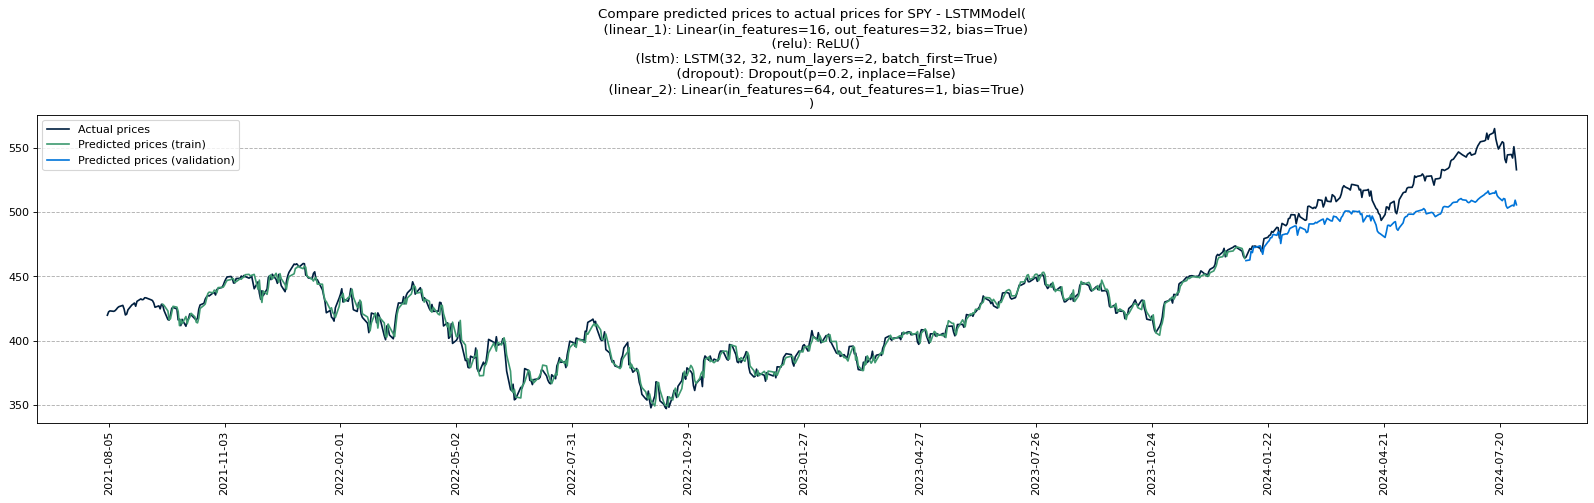

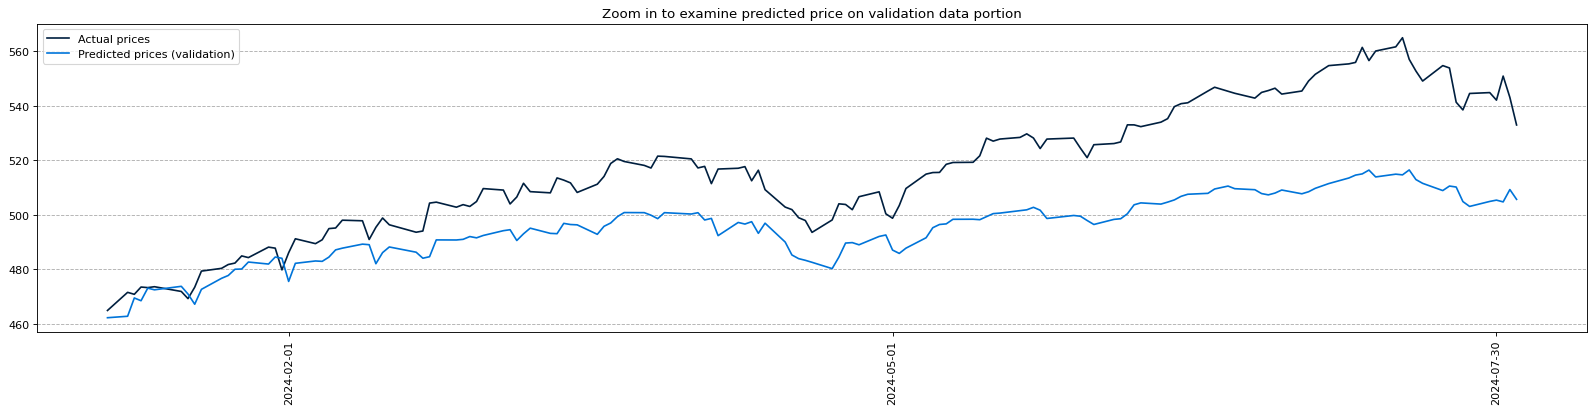

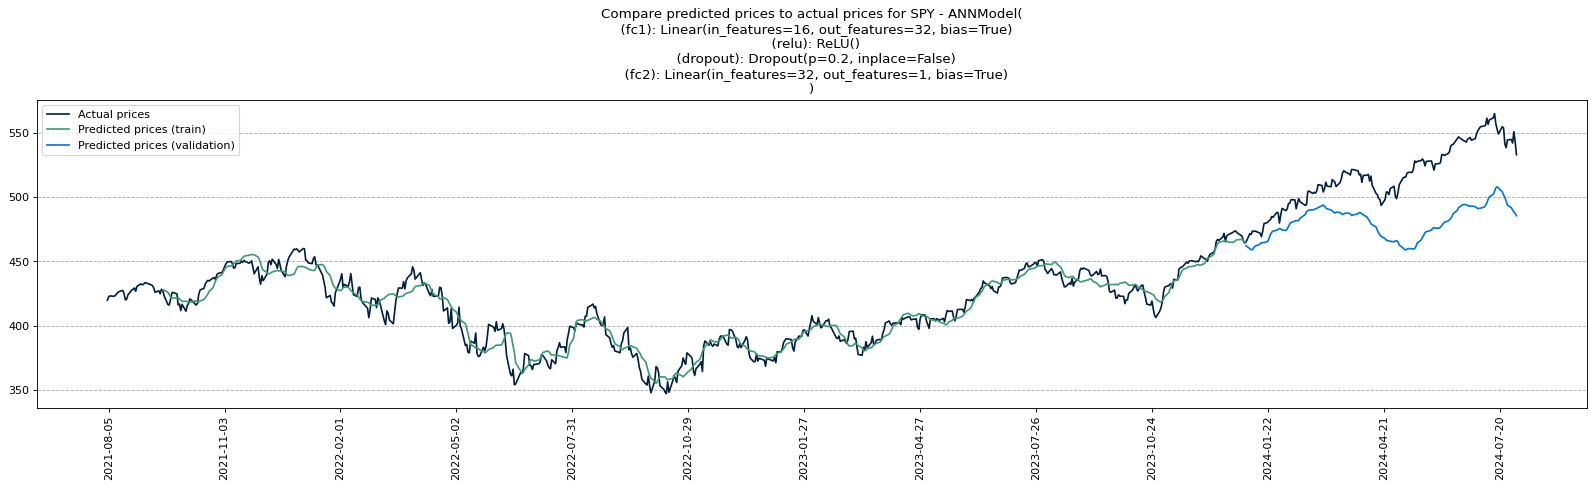

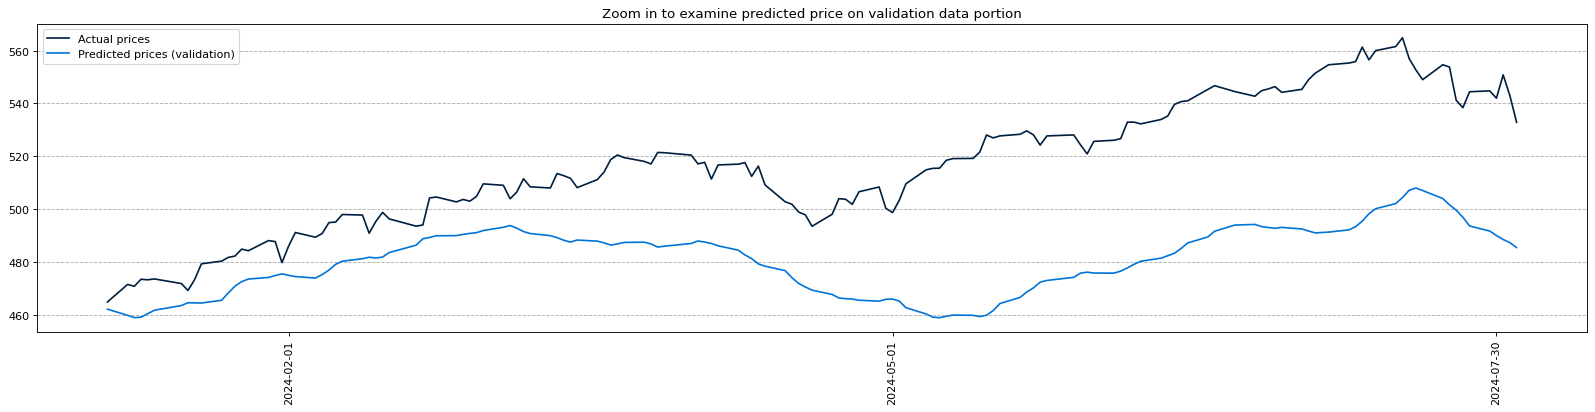

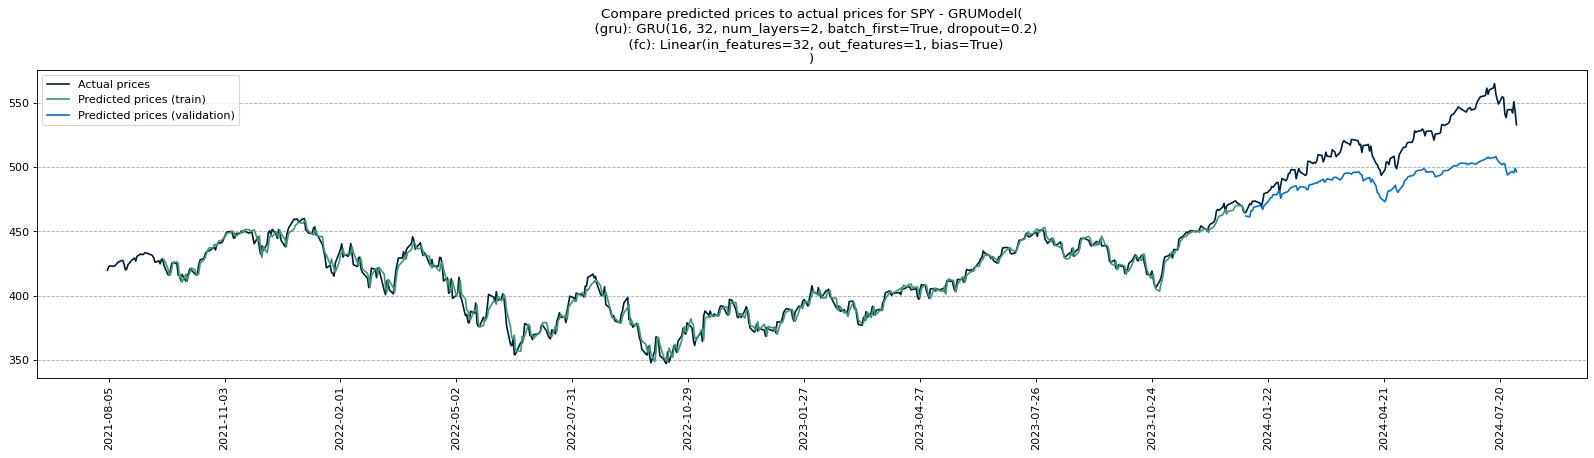

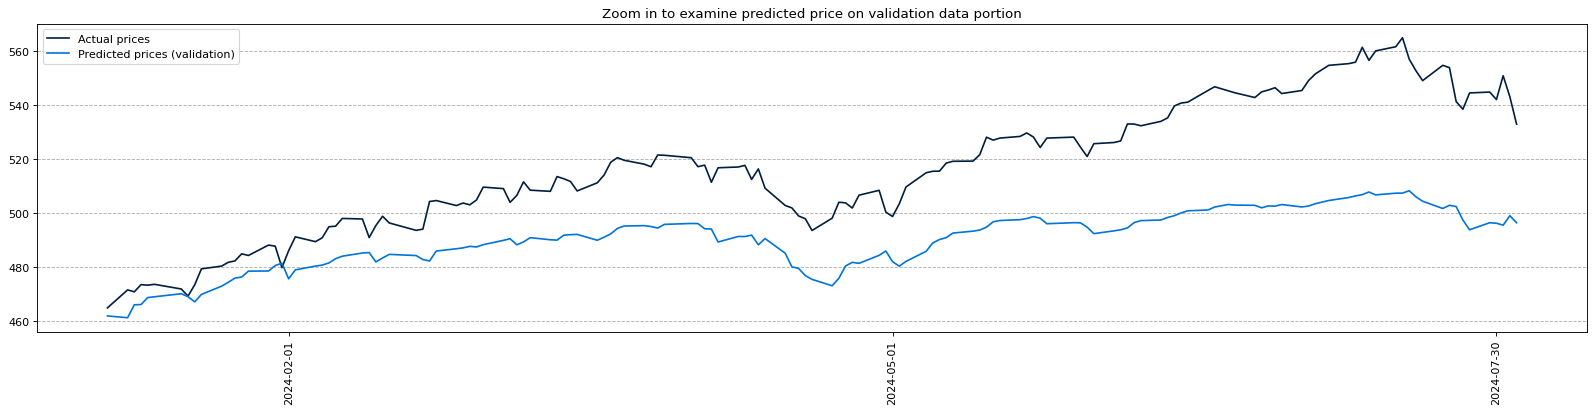

In [155]:
# iterate through each initialized model type to get model evaluate the model
for model_type in model_types:
    # Set model to evaluation mode to prevent any changes to the model parameters
    model_type.eval()

    # Container for the model predictions on training data
    predicted_train = np.array([])

    # Predict on the training data
    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(config["training"]["device"])  # Ensure data is on the correct device
        out = model_type(x)
        out = out.view(out.size(0), -1).mean(dim=1)  # Reshape and average the output
        out = out.cpu().detach().numpy()  # Detach output from computation graph and convert to numpy array
        predicted_train = np.concatenate((predicted_train, out))

    # Container for the model predictions on validation data
    predicted_val = np.array([])

    # Predict on the validation data
    for idx, (x, y) in enumerate(val_dataloader):
        x = x.to(config["training"]["device"])  # Ensure data is on the correct device
        out = model_type(x)
        out = out.view(out.size(0), -1).mean(dim=1)  # Reshape and average the output
        out = out.cpu().detach().numpy()  # Detach output from computation graph and convert to numpy array
        predicted_val = np.concatenate((predicted_val, out))

    # Prepare data for plotting
    num_data_points = len(data_date)  # Assuming data_date is already available
    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    # Inverse transform the normalized predictions back to original scale
    # Ensure the correct scaler is used for inverse transformation
    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index + config["data"]["window_size"]] = single_feature_scaler.inverse_transform(predicted_train.reshape(-1, 1)).flatten()
    to_plot_data_y_val_pred[split_index + config["data"]["window_size"]:] = single_feature_scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()

    # Replace zero values with None for better plot readability
    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # Ensure data_date is in datetime format for plotting
    data_date = pd.to_datetime(data_date)

    # Plot the actual and predicted prices for training and validation data per model
    plot_prices(
        data_date=data_date,
        data_series=[data_close_price, to_plot_data_y_train_pred, to_plot_data_y_val_pred],
        labels=["Actual prices", "Predicted prices (train)", "Predicted prices (validation)"],
        colors=colors,
        title=f"Compare predicted prices to actual prices for {config['alpha_vantage']['symbol']} - {model_type}"
    )


    # Reshape the arrays and inverse transform the data to get it back to the original scale
    to_plot_data_y_val_subset = single_feature_scaler.inverse_transform(data_y_val.reshape(-1, 1))
    to_plot_predicted_val = single_feature_scaler.inverse_transform(predicted_val.reshape(-1, 1))
    to_plot_data_date = data_date[split_index + config["data"]["window_size"]:]  # Assuming full_date is the new name of your date array

    # Extract colors from config
    color_actual = config["plots"]["color_actual"]
    color_pred_val = config["plots"]["color_pred_val"]

    # Create figure and axes object
    fig, ax = plt.subplots(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    # Plot data
    ax.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=color_actual)
    ax.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=color_pred_val)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))  # Set interval to your preference
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation='vertical')
    # Set title, grid, and legend
    ax.set_title("Zoom in to examine predicted price on validation data portion")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.legend()

    # Show plot
    plt.show()

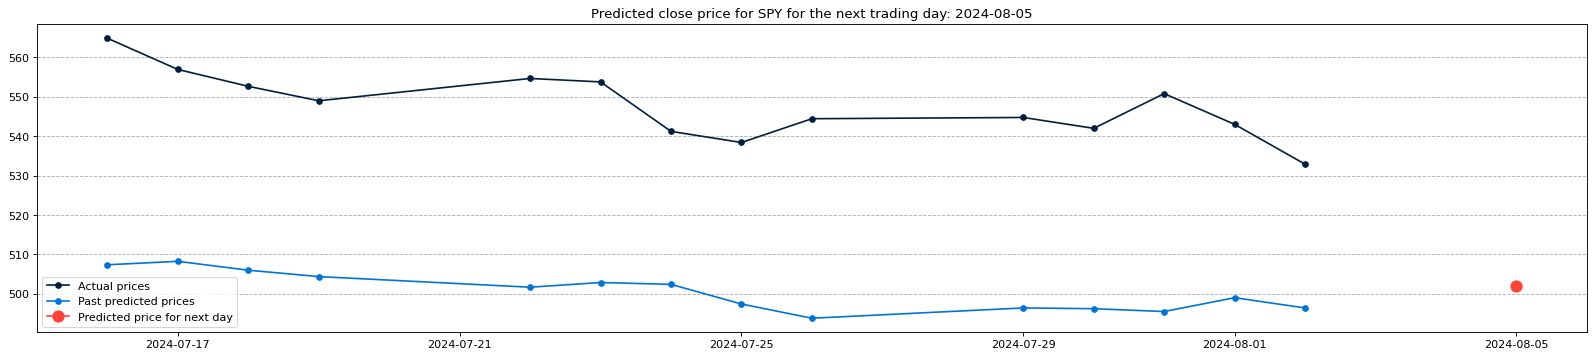

For model LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
), the predicted close price SPY of the next trading day: 502.07
For model LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
), the Mean Absolute Error (MAE): 0.12
For model LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
), the Median Absolute Error (MedAE): 0.12
For model LSTMModel(
  (linear_1): Linear(in_features=16, 

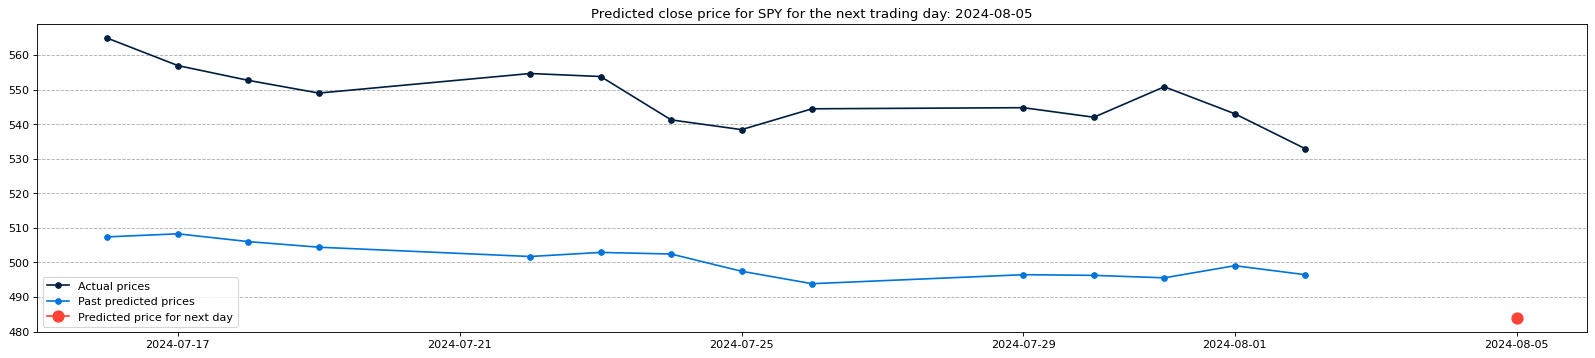

For model ANNModel(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
), the predicted close price SPY of the next trading day: 483.84
For model ANNModel(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
), the Mean Absolute Error (MAE): 0.12
For model ANNModel(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
), the Median Absolute Error (MedAE): 0.12
For model ANNModel(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
), the Mean Absolute Percentage Error (MAPE): 14.73%


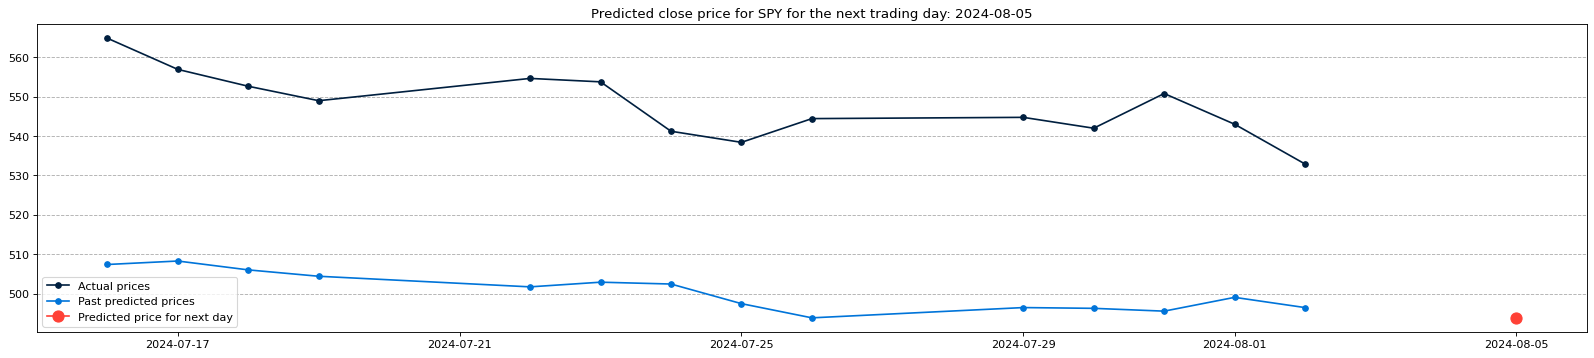

For model GRUModel(
  (gru): GRU(16, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the predicted close price SPY of the next trading day: 493.73
For model GRUModel(
  (gru): GRU(16, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the Mean Absolute Error (MAE): 0.12
For model GRUModel(
  (gru): GRU(16, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the Median Absolute Error (MedAE): 0.12
For model GRUModel(
  (gru): GRU(16, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the Mean Absolute Percentage Error (MAPE): 14.73%


In [156]:
# Iterate through each initialized model type to get model evaluate the model
for model_type in model_types:
    # Assuming you have already loaded the required libraries and modules

    # Set the model to evaluation mode
    model_type.eval()

    # Prepare the unseen data
    x_unseen = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0)
    # Assuming data_x_unseen has the shape [sequence_length, num_features]

    # Make a prediction using the model
    prediction = model_type(x_unseen)
    prediction = prediction.view(prediction.size(0), -1).mean(dim=1)  # Reshape and average the output
    prediction = prediction.cpu().detach().numpy()

    # Prepare data for plotting
    plot_range = 15  # You can adjust this value as per your requirements
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    # Inverse transform the data to get it back to the original scale
    to_plot_data_y_val = single_feature_scaler.inverse_transform(data_y_val[-plot_range + 1:].reshape(-1, 1)).flatten()
    to_plot_data_y_val_pred = single_feature_scaler.inverse_transform(predicted_val[-plot_range + 1:].reshape(-1, 1)).flatten()
    #to_plot_data_y_test_pred = single_feature_scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()




    # Create a list of dates for plotting
    plot_date_test = data_date[-plot_range + 1:].tolist()
    # Convert the last date in your dataset to a datetime object (if it's not already)
    # last_date = pd.to_datetime(data_date[-1])
    # # Compute the date for "tomorrow" by adding one day to the last date
    # tomorrow_date = last_date + pd.Timedelta(days=1)
    # # Append tomorrow_date to plot_date_test
    # plot_date_test.append(tomorrow_date)



    # Convert the last date in your dataset to a datetime object (if it's not already)
    last_date = pd.to_datetime(data_date[-1])
    # Check the day of the week: 0 = Monday, 1 = Tuesday, ..., 4 = Friday, 5 = Saturday, 6 = Sunday
    day_of_week = last_date.weekday()

    # Compute the date for the next trading day by adding one day to the last date,
    # or three days if the last date is a Friday, or two days if it's a Saturday.
    if day_of_week == 4:
        next_trading_day = last_date + pd.Timedelta(days=3)
    elif day_of_week == 5:
        next_trading_day = last_date + pd.Timedelta(days=2)
    else:
        next_trading_day = last_date + pd.Timedelta(days=1)

    # Append next_trading_day to plot_date_test
    plot_date_test.append(next_trading_day)



    # Append a None value to to_plot_data_y_val to match the length of plot_date_test
    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, np.nan, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, np.nan, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, np.nan, to_plot_data_y_test_pred)

    # Append a np.nan value to to_plot_data_y_val and to_plot_data_y_val_pred to match the length of plot_date_test
    to_plot_data_y_val = np.append(to_plot_data_y_val, np.nan)
    to_plot_data_y_val_pred = np.append(to_plot_data_y_val_pred, np.nan)

    to_plot_data_y_test_pred = np.full(len(plot_date_test), np.nan)
    # Set the last entry to the predicted value for "tomorrow"
    to_plot_data_y_test_pred[-1] = single_feature_scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()[0]



    # Now the lengths should match and you can proceed with plotting
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title(f"Predicted close price for {symbol} for the next trading day: {plot_date_test[-1].strftime('%Y-%m-%d')}")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend(loc = 'lower left')
    plt.show()

    predicted_price = to_plot_data_y_test_pred[-1]
    if np.isnan(predicted_price):
        print("Predicted close price of the next trading day is unavailable.")
    else:
        print(f"For model {model_type}, the predicted close price {symbol} of the next trading day:", round(predicted_price, 2))

    # Assuming predicted_val is the array of predicted values and data_y_val is the array of actual values
    # Ensure both arrays have the same length and corresponding elements refer to the same dates

    # Calculating the absolute differences
    abs_diff = np.abs(predicted_val - data_y_val)

    # Calculating the percentage differences
    percent_diff = np.abs((predicted_val - data_y_val) / data_y_val) * 100

    # Calculating Mean Absolute Error (MAE)
    mae = np.mean(abs_diff)
    print(f'For model {model_type}, the Mean Absolute Error (MAE): {mae:.2f}')
    # Calculating Median Absolute Error (MedAE)
    medae = np.median(np.abs(predicted_val - data_y_val))
    print(f'For model {model_type}, the Median Absolute Error (MedAE): {medae:.2f}')

    # # Calculating Mean Absolute Percentage Error (MAPE)
    mape = np.mean(percent_diff)
    print(f'For model {model_type}, the Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

